# <center>Лабораторна робота 1</center>
<center><b>Дмитренко ФБ-04</b></center>


Lab 1: Базові алгоритми класифікації з використанням бібліотеки Scikit-learn

---

### Хід роботи

Використовуємо датасет Lung Cancer [Kaggle](https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer/data/)

## Імпорти, читання, аналіз

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Виконання роботи

### 1) Завантажити дані, вивести назви колонок і розмір датасета

In [55]:
df = pd.read_csv("president_county_candidate.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32177 entries, 0 to 32176
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        32177 non-null  object
 1   county       32177 non-null  object
 2   candidate    32177 non-null  object
 3   party        32177 non-null  object
 4   total_votes  32177 non-null  int64 
 5   won          32177 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.3+ MB


In [56]:
# Видалення колонки 'county'
df = df.drop(columns=['county'])

# Оставити тільки двох топ кандидатів, інших помітити як 'other'
top_candidates = df['candidate'].value_counts().nlargest(2).index
mask_candidate = df['candidate'].isin(top_candidates)
df.loc[~mask_candidate, 'candidate'] = 'other'

# Аналогічно для партій (party)
top_parties = df['party'].value_counts().nlargest(2).index
mask_party = df['party'].isin(top_parties)
df.loc[~mask_party, 'party'] = 'other'

# Групування даних по штату, кандидату та партії, підсумовування голосів
df = df.groupby(['state', 'candidate', 'party'])['total_votes'].sum().reset_index()

In [57]:
df.head()

,state,candidate,party,total_votes
0,Alabama,Donald Trump,REP,1441168
1,Alabama,Joe Biden,DEM,849648
2,Alabama,other,other,32488
3,Alaska,Donald Trump,REP,189892
4,Alaska,Joe Biden,DEM,153405


In [58]:
print("Назви колонок:", df.columns)
print("Розмір датасету:", df.shape)

Назви колонок: Index(['state', 'candidate', 'party', 'total_votes'], dtype='object')
Розмір датасету: (153, 4)


### 2) Опрацювати пропуски (по можливості заповнити їх або видалити)

In [59]:
missing_values = df.isnull().sum()
print("Кількість пропусків у колонках:\n", missing_values)

Кількість пропусків у колонках:
 state          0
candidate      0
party          0
total_votes    0
dtype: int64


Як бачу у датасеті немає пропусків, але так як це вже 3й датасет, тому для не числових колонок заповню пропуски найпопулянрішмим значеннями, а для числових значень -- середніми (що не робив, проте хай буде)

In [60]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

### 3) Візуалізувати дані

#### 3.1) Heatmap 

Так як у датасеті є не інтові значення, перетворю їх на int використовуючи .astype('category').cat.codes

In [61]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category').cat.codes

In [62]:
df.head()

,state,candidate,party,total_votes
0,0,0,1,1441168
1,0,1,0,849648
2,0,2,2,32488
3,1,0,1,189892
4,1,1,0,153405


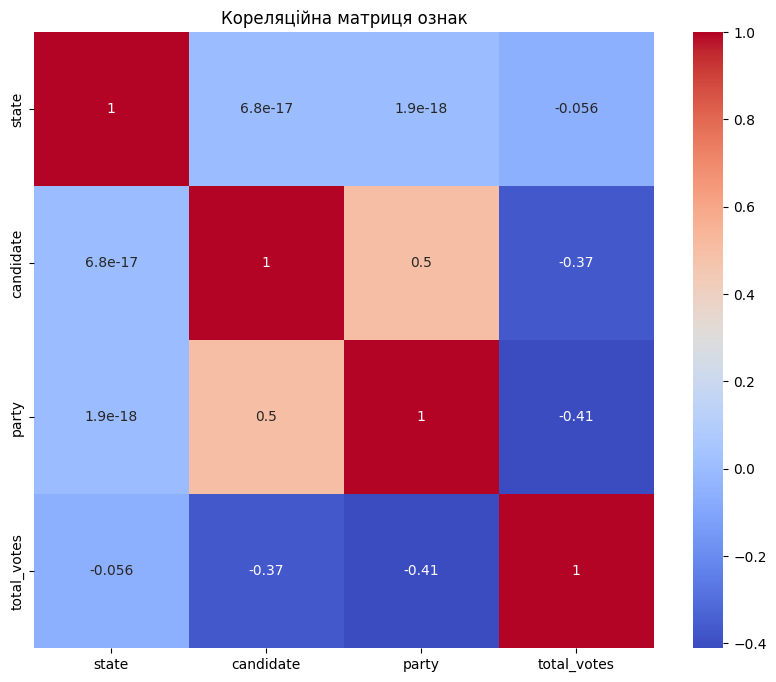

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Кореляційна матриця ознак')
plt.show()

#### 3.2) Гістограма 

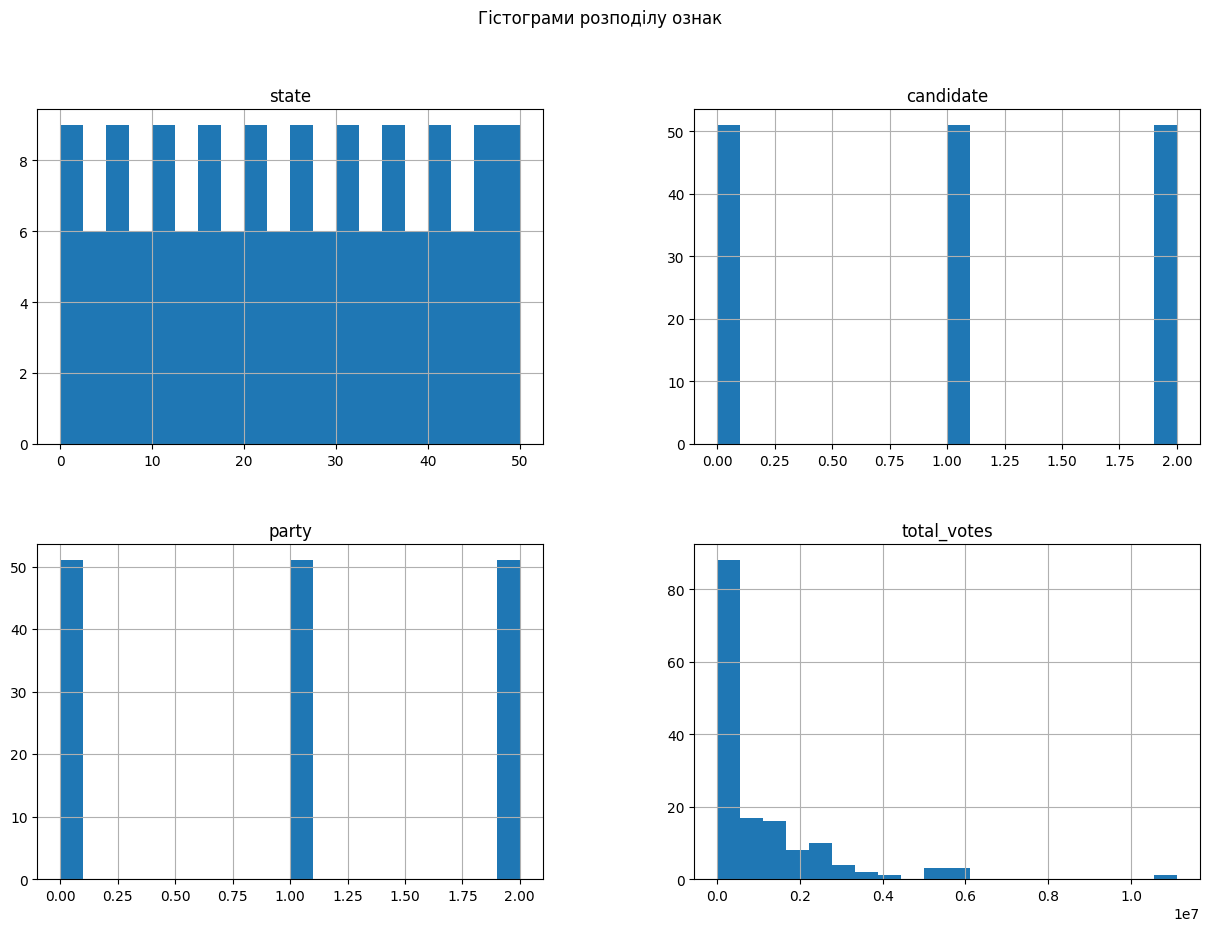

In [64]:
df.hist(figsize=(15, 10), bins=20)
plt.suptitle('Гістограми розподілу ознак')
plt.show()

#### 3.3) Boxplot 

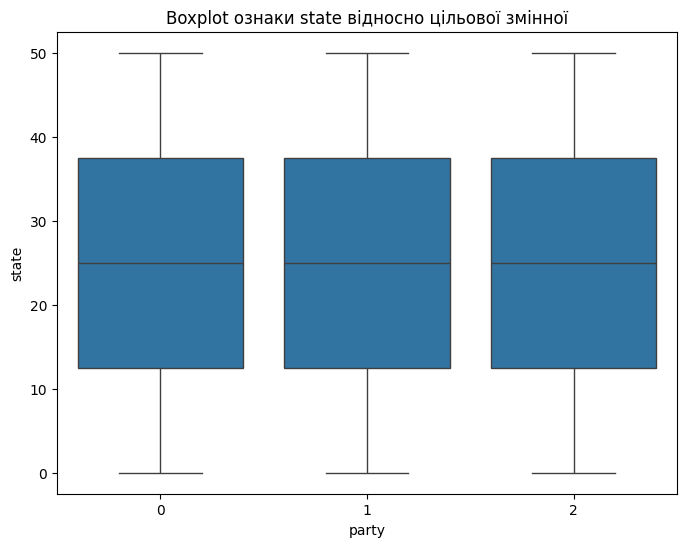

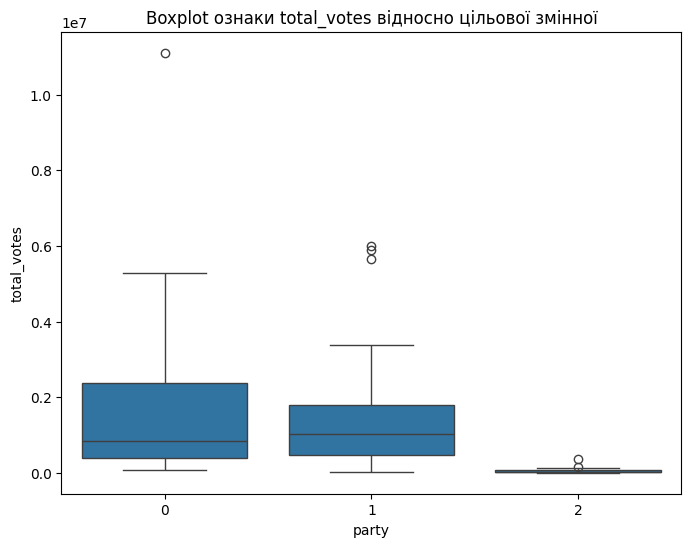

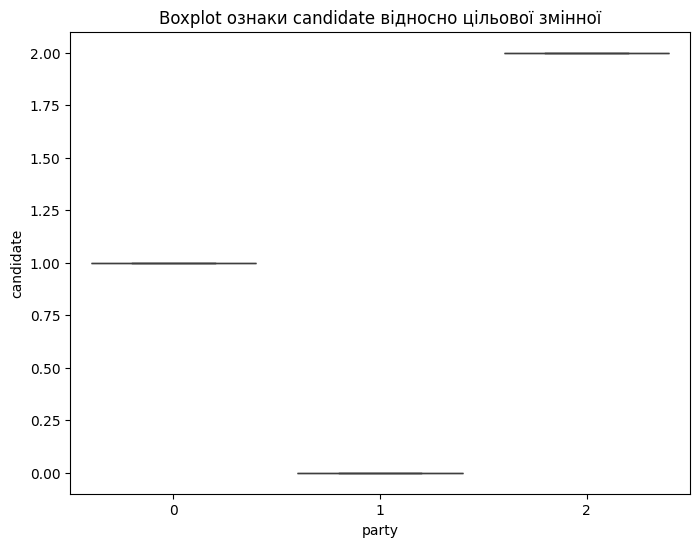

In [65]:
target = 'party'
features = set(df.columns)
features.remove(target)
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f'Boxplot ознаки {feature} відносно цільової змінної')
    plt.show()


### 4) Нормалізувати дані

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
X = df.drop(columns=[target])
y = df[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 5) Провести навчання класифікаторів

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### 5.1) KNN 

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [71]:
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': range(1, 20)}
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_

#### 5.2) Decision Tree 

In [72]:
from sklearn.tree import DecisionTreeClassifier

In [73]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### 5.3) SVM

In [74]:
from sklearn.svm import SVC

In [75]:
svm = SVC()
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

#### 5.4) Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### 5.4) AdaBoost

In [78]:
from sklearn.ensemble import AdaBoostClassifier

In [79]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

### 6) Оцінка моделей

In [80]:
from sklearn.metrics import classification_report, confusion_matrix

In [81]:
models = {'KNN': best_knn, 'Decision Tree': tree, 'SVM': best_svm, 'Random Forest': rf, 'AdaBoost': ada}

for name, model in models.items():
    print(f"Модель: {name}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Матриця неточностей:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

Модель: KNN
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.94      0.97        18
           2       1.00      1.00      1.00         6

    accuracy                           0.97        31
   macro avg       0.96      0.98      0.97        31
weighted avg       0.97      0.97      0.97        31

Матриця неточностей:
[[ 7  0  0]
 [ 1 17  0]
 [ 0  0  6]]


Модель: Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00         6

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Матриця неточностей:
[[ 7  0  0]
 [ 0 18  0]
 [ 0  0  6]]


Модель: SVM
              precision    recall  f1-score   support

           0     